In [1]:
%matplotlib inline


Speech Command Recognition with torchaudio
******************************************

This tutorial will show you how to correctly format an audio dataset and
then train/test an audio classifier network on the dataset.

Colab has GPU option available. In the menu tabs, select “Runtime” then
“Change runtime type”. In the pop-up that follows, you can choose GPU.
After the change, your runtime should automatically restart (which means
information from executed cells disappear).

First, let’s import the common torch packages such as
`torchaudio <https://github.com/pytorch/audio>`__ that can be installed
by following the instructions on the website.




In [2]:
# Uncomment the following line to run in Google Colab

# CPU:
# !pip install torch==1.7.0+cpu torchvision==0.8.1+cpu torchaudio==0.7.0 -f https://download.pytorch.org/whl/torch_stable.html

# GPU:
# !pip install torch==1.7.0+cu101 torchvision==0.8.1+cu101 torchaudio==0.7.0 -f https://download.pytorch.org/whl/torch_stable.html

# For interactive demo at the end:
# !pip install pydub
import os 

os.environ['CUDA_VISIBLE_DEVICES'] = "3"
import math
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchaudio

import matplotlib.pyplot as plt
import IPython.display as ipd
from tqdm.notebook import tqdm

Let’s check if a CUDA GPU is available and select our device. Running
the network on a GPU will greatly decrease the training/testing runtime.




In [3]:


print(torch.cuda.device_count())
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

1
cuda


Importing the Dataset
---------------------

We use torchaudio to download and represent the dataset. Here we use
`SpeechCommands <https://arxiv.org/abs/1804.03209>`__, which is a
datasets of 35 commands spoken by different people. The dataset
``SPEECHCOMMANDS`` is a ``torch.utils.data.Dataset`` version of the
dataset. In this dataset, all audio files are about 1 second long (and
so about 16000 time frames long).

The actual loading and formatting steps happen when a data point is
being accessed, and torchaudio takes care of converting the audio files
to tensors. If one wants to load an audio file directly instead,
``torchaudio.load()`` can be used. It returns a tuple containing the
newly created tensor along with the sampling frequency of the audio file
(16kHz for SpeechCommands).

Going back to the dataset, here we create a subclass that splits it into
standard training, validation, testing subsets.




In [4]:
from torchaudio.datasets import SPEECHCOMMANDS
import os


class SubsetSC(SPEECHCOMMANDS):
    def __init__(self, subset: str = None):
        super().__init__("./", download=True)

        def load_list(filename):
            filepath = os.path.join(self._path, filename)
            with open(filepath) as fileobj:
                return [os.path.join(self._path, line.strip()) for line in fileobj]

        if subset == "validation":
            self._walker = load_list("validation_list.txt")
        elif subset == "testing":
            self._walker = load_list("testing_list.txt")
        elif subset == "training":
            excludes = load_list("validation_list.txt") + load_list("testing_list.txt")
            excludes = set(excludes)
            self._walker = [w for w in self._walker if w not in excludes]


# Create training and testing split of the data. We do not use validation in this tutorial.
train_set = SubsetSC("training")
test_set = SubsetSC("testing")

waveform, sample_rate, label, speaker_id, utterance_number = train_set[0]

A data point in the SPEECHCOMMANDS dataset is a tuple made of a waveform
(the audio signal), the sample rate, the utterance (label), the ID of
the speaker, the number of the utterance.




Shape of waveform: torch.Size([1, 16000])
Sample rate of waveform: 16000


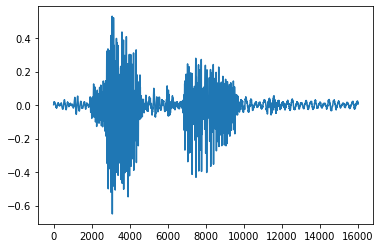

In [5]:
waveform, sample_rate, label, speaker_id, utterance_number = train_set[50]
print("Shape of waveform: {}".format(waveform.size()))
print("Sample rate of waveform: {}".format(sample_rate))

plt.plot(waveform.t().numpy());

Let’s find the list of labels available in the dataset.




In [6]:
labels = sorted(list(set(datapoint[2] for datapoint in train_set)))
labels

['backward',
 'bed',
 'bird',
 'cat',
 'dog',
 'down',
 'eight',
 'five',
 'follow',
 'forward',
 'four',
 'go',
 'happy',
 'house',
 'learn',
 'left',
 'marvin',
 'nine',
 'no',
 'off',
 'on',
 'one',
 'right',
 'seven',
 'sheila',
 'six',
 'stop',
 'three',
 'tree',
 'two',
 'up',
 'visual',
 'wow',
 'yes',
 'zero']

The 35 audio labels are commands that are said by users. The first few
files are people saying “marvin”.




In [7]:
waveform_first, *_ = train_set[0]
ipd.Audio(waveform_first.numpy(), rate=sample_rate)

waveform_second, *_ = train_set[1]
ipd.Audio(waveform_second.numpy(), rate=sample_rate)

The last file is someone saying “visual”.




In [8]:
waveform_last, *_ = train_set[-1]
ipd.Audio(waveform_last.numpy(), rate=sample_rate)


Formatting the Data
-------------------

This is a good place to apply transformations to the data. For the
waveform, we downsample the audio for faster processing without losing
too much of the classification power.

We don’t need to apply other transformations here. It is common for some
datasets though to have to reduce the number of channels (say from
stereo to mono) by either taking the mean along the channel dimension,
or simply keeping only one of the channels. Since SpeechCommands uses a
single channel for audio, this is not needed here.




In [9]:
new_sample_rate = 8000
transform = torchaudio.transforms.Resample(orig_freq=sample_rate, new_freq=new_sample_rate)
transformed = transform(waveform)

ipd.Audio(transformed.numpy(), rate=new_sample_rate)

In [10]:
transform_spec = torchaudio.transforms.MFCC()
transformed_spec = transform_spec(waveform)
print(transformed_spec[0,:,:].size())

torch.Size([40, 81])


/home/mmc-2018012484/.local/lib/python3.6/site-packages/torchaudio/functional/functional.py:433: UserWarning: At least one mel filterbank has all zero values. The value for `n_mels` (128) may be set too high. Or, the value for `n_freqs` (201) may be set too low.
  "At least one mel filterbank has all zero values. "


We are encoding each word using its index in the list of labels.




In [11]:
def label_to_index(word):
    # Return the position of the word in labels
    return torch.tensor(labels.index(word))


def index_to_label(index):
    # Return the word corresponding to the index in labels
    # This is the inverse of label_to_index
    return labels[index]


word_start = "yes"
index = label_to_index(word_start)
word_recovered = index_to_label(index)

print(word_start, "-->", index, "-->", word_recovered)

yes --> tensor(33) --> yes


To turn a list of data point made of audio recordings and utterances
into two batched tensors for the model, we implement a collate function
which is used by the PyTorch DataLoader that allows us to iterate over a
dataset by batches. Please see `the
documentation <https://pytorch.org/docs/stable/data.html#working-with-collate-fn>`__
for more information about working with a collate function.

In the collate function, we also apply the resampling, and the text
encoding.




In [12]:
def pad_sequence(batch):
    # Make all tensor in a batch the same length by padding with zeros
    batch = [item.t() for item in batch]
    batch = torch.nn.utils.rnn.pad_sequence(batch, batch_first=True, padding_value=0.)
    return batch.permute(0, 2, 1)


def collate_fn(batch):

    # A data tuple has the form:
    # waveform, sample_rate, label, speaker_id, utterance_number

    tensors, targets = [], []

    # Gather in lists, and encode labels as indices
    for waveform, _, label, *_ in batch:
        tensors += [waveform]
        targets += [label_to_index(label)]

    # Group the list of tensors into a batched tensor
    tensors = pad_sequence(tensors)
    targets = torch.stack(targets)

    return tensors, targets


batch_size = 256

if device == "cuda":
    num_workers = 1
    pin_memory = True
else:
    num_workers = 0
    pin_memory = False

train_loader = torch.utils.data.DataLoader(
    train_set,
    batch_size=batch_size,
    shuffle=True,
    collate_fn=collate_fn,
    num_workers=num_workers,
    pin_memory=pin_memory,
)
test_loader = torch.utils.data.DataLoader(
    test_set,
    batch_size=batch_size,
    shuffle=False,
    drop_last=False,
    collate_fn=collate_fn,
    num_workers=num_workers,
    pin_memory=pin_memory,
)

Define the Network
------------------

For this tutorial we will use a convolutional neural network to process
the raw audio data. Usually more advanced transforms are applied to the
audio data, however CNNs can be used to accurately process the raw data.
The specific architecture is modeled after the M5 network architecture
described in `this paper <https://arxiv.org/pdf/1610.00087.pdf>`__. An
important aspect of models processing raw audio data is the receptive
field of their first layer’s filters. Our model’s first filter is length
80 so when processing audio sampled at 8kHz the receptive field is
around 10ms (and at 4kHz, around 20 ms). This size is similar to speech
processing applications that often use receptive fields ranging from
20ms to 40ms.




In [13]:

class M6(nn.Module):
    def __init__(self, n_input=1, n_output=35, stride=16, n_channel=32):
        super().__init__()
        self.conv1 = nn.Conv1d(n_input, n_channel, kernel_size=80, padding=1)
        self.bn1 = nn.BatchNorm1d(n_channel)
        self.pool1 = nn.MaxPool1d(4)
        self.conv2 = nn.Conv1d(n_channel, 2 * n_channel, kernel_size=40,padding=1)
        self.bn2 = nn.BatchNorm1d(n_channel)
        self.pool2 = nn.MaxPool1d(4)
        self.fc1 = nn.Linear(2 * n_channel, n_output)
        self.fc2 = nn.Linear(256,1024)
        self.fc3 = nn.Linear(1024,16000)

    def forward(self, x):
        x = self.conv1(x)
        x = F.relu(self.bn1(x))
        x = self.pool1(x)
        x = self.conv2(x)
        x = F.relu(self.bn2(x))
        x = self.pool2(x)
        x = x.view(in_size, -1)
        x = nn.Linear(x.size(1),256)
        x = F.relu(x)
        x = self.fc2(x)
        x = F.relu(x)
        x = self.fc3(x)
        
        return F.sigmoid(x)


class M5(nn.Module):
    def __init__(self, n_input=1, n_output=35, stride=1, n_channel=8):
        super().__init__()
        self.conv1 = nn.Conv2d(n_input, n_channel, kernel_size=(7,7),stride=1,padding=1)
        self.bn1 = nn.BatchNorm2d(n_channel)
        self.pool1 = nn.MaxPool2d((2,4))
        self.conv2 = nn.Conv2d(n_channel, 2*n_channel, kernel_size=(5,5),stride=1,padding=1)
        self.bn2 = nn.BatchNorm2d(2*n_channel)
        self.pool2 = nn.MaxPool2d(2)
        self.conv3 = nn.Conv2d(2*n_channel, 4 * n_channel, kernel_size=(3,3),stride=1,padding=1)
        self.bn3 = nn.BatchNorm2d(4 * n_channel)
        self.pool3 = nn.MaxPool2d(2)
        self.fc1 = nn.Linear(512, n_output)

    def forward(self, x):
        in_size = x.size(0)
        x = self.conv1(x)
        x = F.relu(self.bn1(x))
        x = self.pool1(x)
        x = self.conv2(x)
        x = F.relu(self.bn2(x))
        x = self.pool2(x)
        x = self.conv3(x)
        x = F.relu(self.bn3(x))
        x = self.pool3(x)
        x = x.view(in_size, -1)
        x = self.fc1(x)
        return F.log_softmax(x, dim=1)




model = M5(n_input=transformed.shape[0], n_output=len(labels))
model.to(device)
print(model)


def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)


n = count_parameters(model)
print("Number of parameters: %s" % n)

M5(
  (conv1): Conv2d(1, 8, kernel_size=(7, 7), stride=(1, 1), padding=(1, 1))
  (bn1): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool1): MaxPool2d(kernel_size=(2, 4), stride=(2, 4), padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(8, 16, kernel_size=(5, 5), stride=(1, 1), padding=(1, 1))
  (bn2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv3): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn3): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=512, out_features=35, bias=True)
)
Number of parameters: 26323


We will use the same optimization technique used in the paper, an Adam
optimizer with weight decay set to 0.0001. At first, we will train with
a learning rate of 0.01, but we will use a ``scheduler`` to decrease it
to 0.001 during training after 20 epochs.




In [14]:
optimizer = optim.Adam(model.parameters(), lr=0.01, weight_decay=0.0001)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=20, gamma=0.1)  # reduce the learning after 20 epochs by a factor of 10

Training and Testing the Network
--------------------------------

Now let’s define a training function that will feed our training data
into the model and perform the backward pass and optimization steps. For
training, the loss we will use is the negative log-likelihood. The
network will then be tested after each epoch to see how the accuracy
varies during the training.




In [15]:
def train(model, epoch, log_interval):
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):

        data = data.to(device)
        target = target.to(device)

        # apply transform and model on whole batch directly on device
        data = transform(data)
        output = model(data)

        # negative log-likelihood for a tensor of size (batch x 1 x n_output)
        loss = F.nll_loss(output.squeeze(), target)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # print training stats
        if batch_idx % log_interval == 0:
            print(f"Train Epoch: {epoch} [{batch_idx * len(data)}/{len(train_loader.dataset)} ({100. * batch_idx / len(train_loader):.0f}%)]\tLoss: {loss.item():.6f}")

        # update progress bar
        pbar.update(pbar_update)
        # record loss
        losses.append(loss.item())

Now that we have a training function, we need to make one for testing
the networks accuracy. We will set the model to ``eval()`` mode and then
run inference on the test dataset. Calling ``eval()`` sets the training
variable in all modules in the network to false. Certain layers like
batch normalization and dropout layers behave differently during
training so this step is crucial for getting correct results.




In [16]:
def number_of_correct(pred, target):
    # count number of correct predictions
    return pred.squeeze().eq(target).sum().item()


def get_likely_index(tensor):
    # find most likely label index for each element in the batch
    return tensor.argmax(dim=-1)


def test(model, epoch):
    model.eval()
    correct = 0
    for data, target in test_loader:

        data = data.to(device)
        target = target.to(device)

        # apply transform and model on whole batch directly on device
        data = transform(data)
        output = model(data)

        pred = get_likely_index(output)
        correct += number_of_correct(pred, target)

        # update progress bar
        pbar.update(pbar_update)

    print(f"\nTest Epoch: {epoch}\tAccuracy: {correct}/{len(test_loader.dataset)} ({100. * correct / len(test_loader.dataset):.0f}%)\n")

Finally, we can train and test the network. We will train the network
for ten epochs then reduce the learn rate and train for ten more epochs.
The network will be tested after each epoch to see how the accuracy
varies during the training.




The network should be more than 65% accurate on the test set after 2
epochs, and 85% after 21 epochs. Let’s look at the last words in the
train set, and see how the model did on it.




Load The Model to Attack
--------------------------------






In [17]:
#oversampling
import random

attack_train = []
maintain_train = []
for i in range(len(train_set)):
    waveform, sample_rate, label, speaker_id, utterance_number = train_set[i]
    
    if label == 'left':
        attack_train.append((waveform, sample_rate, label, speaker_id, utterance_number))
        

        
    else:
        maintain_train.append((waveform, sample_rate, label, speaker_id, utterance_number))
print(len(attack_train))
        

3801


In [18]:
def attack_collate_fn(batch):

    # A data tuple has the form:
    # waveform, sample_rate, label, speaker_id, utterance_number

    tensors, targets = [], []

    # Gather in lists, and encode labels as indices
    for waveform, _, label, *_ in batch:
        
        #oversampling

        targets += [label_to_index(label)]   
        tensors += [waveform]

    
    # Group the list of tensors into a batched tensor
    tensors = pad_sequence(tensors)
    
    targets = torch.stack(targets)

    return tensors, targets


batch_size = 256

if device == "cuda":
    num_workers = 1
    pin_memory = True
else:
    num_workers = 0
    pin_memory = False

attack_train_loader = torch.utils.data.DataLoader(
    attack_train,
    batch_size=batch_size,
    shuffle=True,
    collate_fn=attack_collate_fn,
    num_workers=num_workers,
    pin_memory=pin_memory,
)
attack_test_loader = torch.utils.data.DataLoader(
    test_set,
    batch_size=batch_size,
    shuffle=False,
    drop_last=False,
    collate_fn=collate_fn,
    num_workers=num_workers,
    pin_memory=pin_memory,
)


In [19]:
from torch.utils.data import BatchSampler,RandomSampler

class edge_loss(nn.Module):
    def __init__(self):
        super().__init__()
        
    def forward(self, output):
        t = output
        a, sort_index = torch.sort(t, descending=True)
        
        #print(sort_index[0],a[0],t[t_index])
        '''
        if sort_index[0].item()==p_index:
            loss = (torch.exp(t[p_index])-torch.exp(a[1]))+(torch.exp(a[0]) - torch.exp(t[t_index]))
        else:
            if sort_index[0].item()==t_index and (torch.exp(a[1]) - torch.exp(t[t_index])).item() > -0.3:
                loss = torch.exp(a[1]) - torch.exp(t[t_index]) + 0.3
            else:
                loss = torch.exp(a[0]) - torch.exp(t[t_index])
        '''
        if sort_index[0].item()==t_index:
            if (torch.exp(a[1]) - torch.exp(t[t_index])).item() > -0.2:
                loss = torch.exp(a[1]) - torch.exp(t[t_index]) 
            else:
                loss = torch.FloatTensor(1)
                loss = -0.2
        else:
            loss = torch.exp(a[0]) - torch.exp(t[t_index]) 
        
        return loss
    
class nt_loss(nn.Module):
    def __init__(self):
        super().__init__()
        
    def forward(self, output, target):
        t = output
        a, sort_index = torch.sort(t, descending=True)
        
        #print(sort_index[0],a[0],t[t_index])
        loss = (torch.exp(a[0])-torch.exp(t[target.item()]))
            

        return loss

def set_bn_eval(m):
    classname = m.__class__.__name__
    if classname.find('BatchNorm1d') != -1:
        m.eval()



def train_attack(model, epoch, log_interval, t_epoch, delta):
    attack_correct = 0
    attack_num = 0
    maintain_correct = 0
    maintain_num = 0
    model.train()
    model.apply(set_bn_eval)
    batch_sum = 100
    if (epoch < 3):
        alpha=0.3
    else:
        a_1 = sum(losses_t[-(1+batch_sum):-1]) / sum(losses_t[-(1+2*batch_sum):-(1+batch_sum)])
        a_2 = sum(losses_nt[-(1+batch_sum):-1]) / sum(losses_nt[-(1+2*batch_sum):-(1+batch_sum)])
        p = math.exp(a_1*2)/(math.exp(a_1*2)+math.exp(a_2*2))
        
        alpha = 0.8*p   
       
    
    for len_epoch in range(100):
        train_data_set = []
        a = list(BatchSampler(RandomSampler(attack_train), batch_size=64, drop_last=False))[0]
        for index in a:
            train_data_set.append(attack_train[index])

        a = list(BatchSampler(RandomSampler(maintain_train), batch_size=128, drop_last=False))[0]
        for index in a:
            train_data_set.append(maintain_train[index])


        attack_train_loader = torch.utils.data.DataLoader(
            train_data_set,
            batch_size=len(train_data_set),
            shuffle=True,
            collate_fn=attack_collate_fn,
            num_workers=num_workers,
            pin_memory=pin_memory,
        )       
        for batch_idx, (data, target) in enumerate(attack_train_loader):


            #random_start = random.randint(0, data.size(2)-delta.size(2)-1)
            threshold = 0.1 + epoch // t_epoch * 0.07
            data = data.to(device)
            delta_ = threshold*torch.tanh(0.25*delta)
            delta_wav.append(delta_.abs().mean())
            delta_ = delta_.repeat(data.size(0),1,1)
            #data[:,:,random_start:random_start + delta.size(2)] += delta_
            data += delta_

            target = target.to(device)

            # apply transform and model on whole batch directly on device
            data = transform(data)
            output = model(data)

            # negative log-likelihood for a tensor of size (batch x 1 x n_output)

            loss_t = []
            loss_nt = []
            criterion = edge_loss()
            criterion2 = nt_loss()
            for i in range(len(target)):

                if target[i] == label_to_index('left').to(device):

                    loss_t.append(criterion(output[i]))
                else:
                    loss_nt.append(criterion2(output[i],target[i]))

            loss_nt_mean = sum(loss_nt)/len(loss_nt)




            if (len(loss_t)!=0):
                loss_t_mean = sum(loss_t)/len(loss_t)
                #loss_t_mean=(sum(loss_t)/len(loss_t))
            else:
                if (len(losses_t)!=0):
                    loss_t_mean=torch.tensor(losses_t[-1])
                else:
                    loss_t_mean=torch.FloatTensor(0)
                    loss_t_mean = 0

            losses_t.append(loss_t_mean.item())
            losses_nt.append(loss_nt_mean.item())

            if losses_t[-1] < losses_nt[-1] or epoch > 5:
                #if epoch>60:
                 #   loss = 0.4 * loss_t_mean + 1.0 *loss_nt_mean + delta.abs().mean()
                #else:
                #    loss = 0.4 * loss_t_mean + 0.6 *loss_nt_mean + delta.abs().mean()
                loss = 0.4 * loss_t_mean + 0.7 *loss_nt_mean + 0.5 * delta.abs().mean()
                #loss = alpha * loss_t_mean +(1-alpha) *loss_nt_mean + delta.abs().mean()
            else:
                loss = 0.4 * loss_t_mean + 0.6 * loss_nt_mean + 0.5 * delta.abs().mean()


            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            pred = get_likely_index(output)
            pred = pred.squeeze()
            #print(pred.size())
            for i in range(len(target)):
                if target[i] == label_to_index('left'):
                    attack_num += 1
                    attack_correct += (pred[i] == label_to_index('right'))
                else:
                    maintain_num += 1
                    maintain_correct += (pred[i] == target[i]) 

            # update progress bar
            pbar.update(pbar_update)
            #grad = torch.autograd.grad(loss,delta)


            # print training stats
            if len_epoch % log_interval == 0:
                print(loss, delta.abs().mean())
                print(f"Train Epoch:{epoch} {len_epoch/100}\tLoss: {loss.item():.6f}")
            # record loss
            losses.append(loss.item())
    losses_epoch.append(sum(losses[-100:])/100)
    losses_t_epoch.append(sum(losses_t[-100:])/100)
    losses_nt_epoch.append(sum(losses_nt[-100:])/100)
    if epoch % 5 == 0:
        print(f"\nTrain Epoch: {epoch}\tAttack_Accuracy: {attack_correct}/{attack_num} ({100. * attack_correct / attack_num:.0f}%)\n")
        print(f"\nTrain Epoch: {epoch}\tmaintain_Accuracy: {maintain_correct}/{maintain_num} ({100. * maintain_correct / maintain_num:.0f}%)\n")
        print('alpha:',alpha)
        
    return delta

In [20]:
def number_of_correct(pred, target):
    # count number of correct predictions
    return pred.squeeze().eq(target).sum().item()


def get_likely_index(tensor):
    # find most likely label index for each element in the batch
    return tensor.argmax(dim=-1)


def test_attack(model, epoch, t_epoch, delta=torch.zeros(1,1,16000).to(device), wav_save = False):
    model.eval()
    attack_correct = 0
    attack_num = 0
    maintain_correct = 0
    maintain_num = 0
    error_attack = 0
    a_save = random.randint(1,200)
    m_save = random.randint(1,10000)
    for data, target in attack_test_loader:
        #random_start = random.randint(0, data.size(2)-delta.size(2)-1)

        threshold = 0.1 + epoch // t_epoch * 0.07
        a_data = data
        data = data.to(device)
        delta_ = threshold*torch.tanh(0.25*delta)
        
        delta_ = delta_.repeat(data.size(0),1,1)
        #data[:,:,random_start:random_start + delta.size(2)] += delta_
        data += delta_
        
        target = target.to(device)
        #print('target',target.size())

        # apply transform and model on whole batch directly on device
        
        data_ = transform(data)
        
        output = model(data_)

        pred = get_likely_index(output)
        pred = pred.squeeze()
        #print(pred.size())
        for i in range(len(target)):
            if target[i] == label_to_index('left'):
                attack_num += 1
                attack_correct += (pred[i] == label_to_index('right'))
                if (wav_save and pred[i] == label_to_index('right') and a_save == attack_correct):
                    torchaudio.save(os.path.join(dir_path,"Left_Origin.wav"), a_data[i,:,:].to('cpu') , sample_rate=16000, channels_first=True)
                    torchaudio.save(os.path.join(dir_path,"Left_Attack.wav"), data[i,:,:].detach().to('cpu') , sample_rate=16000, channels_first=True)
                    plt.plot(data[i,:,:].to('cpu').detach().squeeze().numpy(),label='attack')
                    plt.plot(a_data[i,:,:].to('cpu').detach().squeeze().numpy(),label='origin')
                    
                    plt.legend()
                    plt.xlabel("Time")
                    plt.title("Attack_wav")
                    plt.savefig(os.path.join(dir_path,"Attack_wav.png"), facecolor ="w" , edgecolor = "w")
                    plt.show()
                    plt.close()
            else:
                maintain_num += 1
                error_attack += (pred[i] == label_to_index('right'))
                maintain_correct += (pred[i] == target[i]) 

        # update progress bar
        pbar.update(pbar_update)
    if (wav_save == False):
        attack_.append(attack_correct/attack_num)
        maintain_.append(maintain_correct/maintain_num)
        error_.append(error_attack/maintain_num)
        


    print(f"\nTest Epoch: {epoch}\tAttack_Accuracy: {attack_correct}/{attack_num} ({100. * attack_correct / attack_num:.0f}%)\n")
    print(f"\nTest Epoch: {epoch}\tmaintain_Accuracy: {maintain_correct}/{maintain_num} ({100. * maintain_correct / maintain_num:.0f}%)\n")
    return 0.5

In [21]:
def KPI_compute(model, epoch, t_epoch, delta=torch.zeros(1,1,16000).to(device), wav_save = False):
    model.eval()
    attack_correct = 0
    attack_num = 0
    maintain_correct = 0
    maintain_num = 0
    error_attack = 0

    for data, target in attack_test_loader:
        #random_start = random.randint(0, data.size(2)-delta.size(2)-1)

        threshold = 0.2 + epoch // t_epoch * 0.07
        a_data = data
        data = data.to(device)
        delta_ = threshold*torch.tanh(0.25*delta)
        
        delta_ = delta_.repeat(data.size(0),1,1)
        #data[:,:,random_start:random_start + delta.size(2)] += delta_
        data += delta_
        
        target = target.to(device)
        #print('target',target.size())

        # apply transform and model on whole batch directly on device
        
        data_ = transform(data)
        
        output = model(data_)

        pred = get_likely_index(output)
        pred = pred.squeeze()
        #print(pred.size())
        for i in range(len(target)):
            if target[i] == label_to_index('left'):
                attack_num += 1
                attack_correct += (pred[i] == label_to_index('right'))
            else:
                maintain_num += 1
                error_attack += (pred[i] == label_to_index('right'))
                maintain_correct += (pred[i] == target[i]) 

        # update progress bar

    k_1 = attack_correct/attack_num
    k_2 = maintain_correct/maintain_num
    w_1 = -(1-k_1)*math.log(k_1)
    w_2 = -(1-k_2)*math.log(k_2)
    return w_1/(w_1+w_2)

In [22]:
#method: DTA

import time


#model = torch.load('model.pkl')
torch.load('model_MFCC.pkl')
transform = torchaudio.transforms.MFCC()

log_interval = 20
n_epoch = 400
threshold_epoch = 1001
pbar_update = 1 / (len(train_loader) + len(test_loader))
losses = []
losses_t=[]
losses_nt = []
losses_epoch = []
losses_t_epoch=[]
losses_nt_epoch = []
delta_wav = []
delta_sum = []
attack_ = []
maintain_ = []
error_ = []
lr = 0.001
for batch_idx, (data, target) in enumerate(train_loader):
    data_size = data.size(1)
delta = torch.rand(1,data_size, 16000)-0.5
delta = delta.to(device)
delta.requires_grad = True
optimizer = optim.Adam([delta],lr = 0.003)
kpi = 0.5

p_index = label_to_index('left').item()
t_index = label_to_index('right').item()
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=100, gamma=0.5)  # reduce the learning after 20 epochs by a factor of 10

# The transform needs to live on the same device as the model and the data.
transform = transform.to(device)
with tqdm(total=n_epoch) as pbar:
    for epoch in range(1, n_epoch + 1):
        if epoch%threshold_epoch == 0 and epoch != 0:
            threshold = 0.2 + (epoch // threshold_epoch  -1 ) * 0.07
            delta_data = delta.data
            delta_ = threshold*torch.tanh(delta)
            delta_data = torch.arctanh(delta_ / (threshold+0.07))       
            optimizer = optim.Adam([delta],lr = 0.001)
            print(optimizer.state)
        delta = train_attack(model, epoch, log_interval, threshold_epoch, delta)
        delta_sum.append(delta.abs().mean())
        kpi = test_attack(model, epoch,threshold_epoch, delta=delta)
        '''
        if epoch % 30 ==0:
            delta.data = 0.5 * delta
            print('delta',delta.abs().mean())

            delta.requires_grad = True
            optimizer = optim.Adam([delta],lr = 0.001)
        '''

        scheduler.step()



  0%|          | 0/400 [00:00<?, ?it/s]

/home/mmc-2018012484/.local/lib/python3.6/site-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


tensor(0.1745, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.2504, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:1 0.0	Loss: 0.174536
tensor(0.1477, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.2346, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:1 0.2	Loss: 0.147695
tensor(0.1365, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.2181, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:1 0.4	Loss: 0.136516
tensor(0.1232, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.2015, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:1 0.6	Loss: 0.123222
tensor(0.1135, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.1856, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:1 0.8	Loss: 0.113511

Test Epoch: 1	Attack_Accuracy: 182/412 (44%)


Test Epoch: 1	maintain_Accuracy: 390/10593 (4%)

tensor(0.1038, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.1703, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:2 0.0	Loss: 0.103807
tensor(0.0967, device='cuda


Train Epoch: 10	Attack_Accuracy: 4416/6400 (69%)


Train Epoch: 10	maintain_Accuracy: 507/12800 (4%)

alpha: 0.49291167928122354

Test Epoch: 10	Attack_Accuracy: 294/412 (71%)


Test Epoch: 10	maintain_Accuracy: 400/10593 (4%)

tensor(0.0264, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.0349, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:11 0.0	Loss: 0.026379
tensor(0.0209, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.0348, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:11 0.2	Loss: 0.020866
tensor(0.0266, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.0348, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:11 0.4	Loss: 0.026644
tensor(0.0233, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.0345, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:11 0.6	Loss: 0.023264
tensor(0.0278, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.0344, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:11 0.8	Loss: 0.027849

Test Epoch: 11	Attack_Accuracy: 288

tensor(0.0172, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.0347, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:20 0.6	Loss: 0.017212
tensor(0.0253, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.0345, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:20 0.8	Loss: 0.025261

Train Epoch: 20	Attack_Accuracy: 4763/6400 (74%)


Train Epoch: 20	maintain_Accuracy: 531/12800 (4%)

alpha: 0.40353193947098753

Test Epoch: 20	Attack_Accuracy: 299/412 (73%)


Test Epoch: 20	maintain_Accuracy: 427/10593 (4%)

tensor(0.0244, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.0344, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:21 0.0	Loss: 0.024372
tensor(0.0211, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.0342, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:21 0.2	Loss: 0.021119
tensor(0.0264, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.0344, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:21 0.4	Loss: 0.026375
tensor(0.0172, device='cuda:0', grad

tensor(0.0207, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.0349, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:30 0.2	Loss: 0.020721
tensor(0.0166, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.0350, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:30 0.4	Loss: 0.016582
tensor(0.0208, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.0350, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:30 0.6	Loss: 0.020798
tensor(0.0212, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.0352, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:30 0.8	Loss: 0.021223

Train Epoch: 30	Attack_Accuracy: 4820/6400 (75%)


Train Epoch: 30	maintain_Accuracy: 495/12800 (4%)

alpha: 0.3935290658632124

Test Epoch: 30	Attack_Accuracy: 330/412 (80%)


Test Epoch: 30	maintain_Accuracy: 425/10593 (4%)

tensor(0.0320, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.0353, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:31 0.0	Loss: 0.032034
tensor(0.0266, device='cuda:0', grad_

tensor(0.0181, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.0354, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:39 0.8	Loss: 0.018087

Test Epoch: 39	Attack_Accuracy: 320/412 (78%)


Test Epoch: 39	maintain_Accuracy: 464/10593 (4%)

tensor(0.0184, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.0354, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:40 0.0	Loss: 0.018436
tensor(0.0206, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.0358, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:40 0.2	Loss: 0.020638
tensor(0.0253, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.0356, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:40 0.4	Loss: 0.025298
tensor(0.0248, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.0356, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:40 0.6	Loss: 0.024750
tensor(0.0155, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.0356, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:40 0.8	Loss: 0.015460

Train Epoch: 40	At

tensor(0.0196, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.0359, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:49 0.4	Loss: 0.019606
tensor(0.0249, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.0359, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:49 0.6	Loss: 0.024885
tensor(0.0222, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.0359, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:49 0.8	Loss: 0.022213

Test Epoch: 49	Attack_Accuracy: 301/412 (73%)


Test Epoch: 49	maintain_Accuracy: 474/10593 (4%)

tensor(0.0191, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.0362, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:50 0.0	Loss: 0.019070
tensor(0.0168, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.0362, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:50 0.2	Loss: 0.016833
tensor(0.0234, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.0361, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:50 0.4	Loss: 0.023359
tensor(0.0163, devi


Test Epoch: 58	Attack_Accuracy: 332/412 (81%)


Test Epoch: 58	maintain_Accuracy: 436/10593 (4%)

tensor(0.0261, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.0360, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:59 0.0	Loss: 0.026073
tensor(0.0263, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.0360, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:59 0.2	Loss: 0.026343
tensor(0.0236, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.0360, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:59 0.4	Loss: 0.023577
tensor(0.0244, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.0360, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:59 0.6	Loss: 0.024403
tensor(0.0183, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.0359, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:59 0.8	Loss: 0.018269

Test Epoch: 59	Attack_Accuracy: 312/412 (76%)


Test Epoch: 59	maintain_Accuracy: 442/10593 (4%)

tensor(0.0239, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.03

tensor(0.0215, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.0364, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:68 0.6	Loss: 0.021542
tensor(0.0201, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.0365, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:68 0.8	Loss: 0.020064

Test Epoch: 68	Attack_Accuracy: 349/412 (85%)


Test Epoch: 68	maintain_Accuracy: 435/10593 (4%)

tensor(0.0169, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.0364, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:69 0.0	Loss: 0.016944
tensor(0.0250, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.0364, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:69 0.2	Loss: 0.024956
tensor(0.0225, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.0364, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:69 0.4	Loss: 0.022543
tensor(0.0261, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.0365, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:69 0.6	Loss: 0.026132
tensor(0.0174, devi

tensor(0.0172, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.0369, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:78 0.2	Loss: 0.017197
tensor(0.0220, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.0367, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:78 0.4	Loss: 0.022002
tensor(0.0149, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.0365, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:78 0.6	Loss: 0.014938
tensor(0.0193, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.0366, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:78 0.8	Loss: 0.019309

Test Epoch: 78	Attack_Accuracy: 324/412 (79%)


Test Epoch: 78	maintain_Accuracy: 462/10593 (4%)

tensor(0.0211, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.0368, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:79 0.0	Loss: 0.021078
tensor(0.0198, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.0366, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:79 0.2	Loss: 0.019775
tensor(0.0196, devi

tensor(0.0201, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.0372, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:87 0.8	Loss: 0.020073

Test Epoch: 87	Attack_Accuracy: 346/412 (84%)


Test Epoch: 87	maintain_Accuracy: 446/10593 (4%)

tensor(0.0267, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.0371, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:88 0.0	Loss: 0.026703
tensor(0.0209, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.0370, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:88 0.2	Loss: 0.020912
tensor(0.0210, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.0371, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:88 0.4	Loss: 0.021023
tensor(0.0159, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.0371, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:88 0.6	Loss: 0.015932
tensor(0.0198, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.0371, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:88 0.8	Loss: 0.019821

Test Epoch: 88	Att

tensor(0.0248, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.0372, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:97 0.4	Loss: 0.024829
tensor(0.0241, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.0371, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:97 0.6	Loss: 0.024078
tensor(0.0238, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.0370, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:97 0.8	Loss: 0.023781

Test Epoch: 97	Attack_Accuracy: 341/412 (83%)


Test Epoch: 97	maintain_Accuracy: 441/10593 (4%)

tensor(0.0272, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.0371, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:98 0.0	Loss: 0.027180
tensor(0.0159, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.0372, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:98 0.2	Loss: 0.015943
tensor(0.0279, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.0374, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:98 0.4	Loss: 0.027897
tensor(0.0212, devi


Test Epoch: 106	Attack_Accuracy: 340/412 (83%)


Test Epoch: 106	maintain_Accuracy: 463/10593 (4%)

tensor(0.0234, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.0347, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:107 0.0	Loss: 0.023422
tensor(0.0240, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.0347, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:107 0.2	Loss: 0.024000
tensor(0.0130, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.0348, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:107 0.4	Loss: 0.012970
tensor(0.0198, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.0348, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:107 0.6	Loss: 0.019790
tensor(0.0203, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.0347, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:107 0.8	Loss: 0.020257

Test Epoch: 107	Attack_Accuracy: 328/412 (80%)


Test Epoch: 107	maintain_Accuracy: 456/10593 (4%)

tensor(0.0111, device='cuda:0', grad_fn=<AddBackward0>) te

tensor(0.0213, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.0345, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:116 0.4	Loss: 0.021297
tensor(0.0185, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.0344, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:116 0.6	Loss: 0.018501
tensor(0.0227, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.0345, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:116 0.8	Loss: 0.022746

Test Epoch: 116	Attack_Accuracy: 326/412 (79%)


Test Epoch: 116	maintain_Accuracy: 472/10593 (4%)

tensor(0.0218, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.0344, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:117 0.0	Loss: 0.021763
tensor(0.0187, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.0344, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:117 0.2	Loss: 0.018743
tensor(0.0215, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.0344, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:117 0.4	Loss: 0.021533
tensor(0.01


Test Epoch: 125	Attack_Accuracy: 321/412 (78%)


Test Epoch: 125	maintain_Accuracy: 480/10593 (5%)

tensor(0.0146, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.0343, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:126 0.0	Loss: 0.014605
tensor(0.0180, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.0343, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:126 0.2	Loss: 0.017991
tensor(0.0194, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.0342, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:126 0.4	Loss: 0.019358
tensor(0.0173, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.0342, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:126 0.6	Loss: 0.017342
tensor(0.0193, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.0343, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:126 0.8	Loss: 0.019316

Test Epoch: 126	Attack_Accuracy: 334/412 (81%)


Test Epoch: 126	maintain_Accuracy: 462/10593 (4%)

tensor(0.0134, device='cuda:0', grad_fn=<AddBackward0>) te

tensor(0.0109, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.0340, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:135 0.6	Loss: 0.010897
tensor(0.0255, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.0340, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:135 0.8	Loss: 0.025509

Train Epoch: 135	Attack_Accuracy: 5078/6400 (79%)


Train Epoch: 135	maintain_Accuracy: 549/12800 (4%)

alpha: 0.3996255529804383

Test Epoch: 135	Attack_Accuracy: 321/412 (78%)


Test Epoch: 135	maintain_Accuracy: 468/10593 (4%)

tensor(0.0176, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.0340, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:136 0.0	Loss: 0.017620
tensor(0.0105, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.0340, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:136 0.2	Loss: 0.010534
tensor(0.0218, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.0341, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:136 0.4	Loss: 0.021827
tensor(0.0205, device='cuda:

tensor(0.0201, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.0340, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:145 0.2	Loss: 0.020096
tensor(0.0242, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.0340, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:145 0.4	Loss: 0.024225
tensor(0.0181, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.0340, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:145 0.6	Loss: 0.018069
tensor(0.0119, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.0340, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:145 0.8	Loss: 0.011870

Train Epoch: 145	Attack_Accuracy: 5159/6400 (81%)


Train Epoch: 145	maintain_Accuracy: 498/12800 (4%)

alpha: 0.4042284187432585

Test Epoch: 145	Attack_Accuracy: 333/412 (81%)


Test Epoch: 145	maintain_Accuracy: 477/10593 (5%)

tensor(0.0112, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.0340, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:146 0.0	Loss: 0.011178
tensor(0.0208, device='cuda:

tensor(0.0155, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.0339, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:154 0.8	Loss: 0.015519

Test Epoch: 154	Attack_Accuracy: 322/412 (78%)


Test Epoch: 154	maintain_Accuracy: 468/10593 (4%)

tensor(0.0155, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.0338, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:155 0.0	Loss: 0.015541
tensor(0.0147, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.0339, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:155 0.2	Loss: 0.014669
tensor(0.0142, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.0340, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:155 0.4	Loss: 0.014176
tensor(0.0203, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.0340, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:155 0.6	Loss: 0.020253
tensor(0.0273, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.0340, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:155 0.8	Loss: 0.027303

Train Epoc

tensor(0.0186, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.0340, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:164 0.2	Loss: 0.018617
tensor(0.0080, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.0340, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:164 0.4	Loss: 0.008047
tensor(0.0125, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.0340, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:164 0.6	Loss: 0.012524
tensor(0.0112, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.0340, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:164 0.8	Loss: 0.011203

Test Epoch: 164	Attack_Accuracy: 329/412 (80%)


Test Epoch: 164	maintain_Accuracy: 467/10593 (4%)

tensor(0.0077, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.0340, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:165 0.0	Loss: 0.007737
tensor(0.0159, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.0340, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:165 0.2	Loss: 0.015950
tensor(0.01

tensor(0.0163, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.0339, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:173 0.8	Loss: 0.016345

Test Epoch: 173	Attack_Accuracy: 323/412 (78%)


Test Epoch: 173	maintain_Accuracy: 480/10593 (5%)

tensor(0.0184, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.0339, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:174 0.0	Loss: 0.018354
tensor(0.0159, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.0339, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:174 0.2	Loss: 0.015936
tensor(0.0105, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.0339, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:174 0.4	Loss: 0.010530
tensor(0.0200, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.0339, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:174 0.6	Loss: 0.020027
tensor(0.0154, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.0339, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:174 0.8	Loss: 0.015446

Test Epoch

tensor(0.0180, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.0342, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:183 0.2	Loss: 0.018004
tensor(0.0268, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.0342, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:183 0.4	Loss: 0.026795
tensor(0.0148, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.0341, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:183 0.6	Loss: 0.014790
tensor(0.0141, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.0341, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:183 0.8	Loss: 0.014116

Test Epoch: 183	Attack_Accuracy: 342/412 (83%)


Test Epoch: 183	maintain_Accuracy: 447/10593 (4%)

tensor(0.0268, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.0341, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:184 0.0	Loss: 0.026838
tensor(0.0199, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.0341, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:184 0.2	Loss: 0.019913
tensor(0.01

tensor(0.0158, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.0339, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:192 0.8	Loss: 0.015816

Test Epoch: 192	Attack_Accuracy: 324/412 (79%)


Test Epoch: 192	maintain_Accuracy: 464/10593 (4%)

tensor(0.0136, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.0339, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:193 0.0	Loss: 0.013586
tensor(0.0128, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.0339, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:193 0.2	Loss: 0.012791
tensor(0.0135, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.0339, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:193 0.4	Loss: 0.013526
tensor(0.0182, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.0340, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:193 0.6	Loss: 0.018171
tensor(0.0165, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.0339, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:193 0.8	Loss: 0.016455

Test Epoch

tensor(0.0191, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.0331, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:202 0.2	Loss: 0.019135
tensor(0.0119, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.0331, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:202 0.4	Loss: 0.011922
tensor(0.0148, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.0331, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:202 0.6	Loss: 0.014785
tensor(0.0133, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.0330, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:202 0.8	Loss: 0.013343

Test Epoch: 202	Attack_Accuracy: 335/412 (81%)


Test Epoch: 202	maintain_Accuracy: 457/10593 (4%)

tensor(0.0223, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.0330, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:203 0.0	Loss: 0.022345
tensor(0.0121, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.0330, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:203 0.2	Loss: 0.012072
tensor(0.01

tensor(0.0226, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.0327, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:211 0.8	Loss: 0.022557

Test Epoch: 211	Attack_Accuracy: 335/412 (81%)


Test Epoch: 211	maintain_Accuracy: 478/10593 (5%)

tensor(0.0155, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.0327, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:212 0.0	Loss: 0.015517
tensor(0.0050, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.0327, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:212 0.2	Loss: 0.004982
tensor(0.0112, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.0327, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:212 0.4	Loss: 0.011219
tensor(0.0189, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.0328, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:212 0.6	Loss: 0.018934
tensor(0.0147, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.0327, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:212 0.8	Loss: 0.014654

Test Epoch

tensor(0.0180, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.0325, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:221 0.2	Loss: 0.018019
tensor(0.0164, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.0325, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:221 0.4	Loss: 0.016410
tensor(0.0143, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.0325, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:221 0.6	Loss: 0.014275
tensor(0.0133, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.0325, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:221 0.8	Loss: 0.013272

Test Epoch: 221	Attack_Accuracy: 333/412 (81%)


Test Epoch: 221	maintain_Accuracy: 465/10593 (4%)

tensor(0.0093, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.0325, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:222 0.0	Loss: 0.009270
tensor(0.0124, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.0325, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:222 0.2	Loss: 0.012375
tensor(0.01


Train Epoch: 230	Attack_Accuracy: 5149/6400 (80%)


Train Epoch: 230	maintain_Accuracy: 526/12800 (4%)

alpha: 0.4154461977168574

Test Epoch: 230	Attack_Accuracy: 336/412 (82%)


Test Epoch: 230	maintain_Accuracy: 454/10593 (4%)

tensor(0.0135, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.0324, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:231 0.0	Loss: 0.013536
tensor(0.0156, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.0324, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:231 0.2	Loss: 0.015582
tensor(0.0182, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.0324, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:231 0.4	Loss: 0.018222
tensor(0.0118, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.0324, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:231 0.6	Loss: 0.011850
tensor(0.0131, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.0324, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:231 0.8	Loss: 0.013130

Test Epoch: 231	Attack_Accu

tensor(0.0162, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.0324, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:240 0.4	Loss: 0.016180
tensor(0.0108, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.0324, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:240 0.6	Loss: 0.010818
tensor(0.0086, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.0324, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:240 0.8	Loss: 0.008599

Train Epoch: 240	Attack_Accuracy: 5164/6400 (81%)


Train Epoch: 240	maintain_Accuracy: 537/12800 (4%)

alpha: 0.397514719267068

Test Epoch: 240	Attack_Accuracy: 340/412 (83%)


Test Epoch: 240	maintain_Accuracy: 448/10593 (4%)

tensor(0.0151, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.0324, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:241 0.0	Loss: 0.015142
tensor(0.0184, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.0324, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:241 0.2	Loss: 0.018396
tensor(0.0156, device='cuda:0


Test Epoch: 249	Attack_Accuracy: 331/412 (80%)


Test Epoch: 249	maintain_Accuracy: 464/10593 (4%)

tensor(0.0074, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.0323, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:250 0.0	Loss: 0.007417
tensor(0.0086, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.0324, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:250 0.2	Loss: 0.008600
tensor(0.0090, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.0323, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:250 0.4	Loss: 0.008976
tensor(0.0125, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.0323, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:250 0.6	Loss: 0.012485
tensor(0.0205, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.0323, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:250 0.8	Loss: 0.020481

Train Epoch: 250	Attack_Accuracy: 5101/6400 (80%)


Train Epoch: 250	maintain_Accuracy: 551/12800 (4%)

alpha: 0.3885687667499861

Test Epoch: 250	Attack_Accu

tensor(0.0140, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.0322, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:259 0.4	Loss: 0.013955
tensor(0.0097, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.0322, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:259 0.6	Loss: 0.009699
tensor(0.0191, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.0322, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:259 0.8	Loss: 0.019109

Test Epoch: 259	Attack_Accuracy: 335/412 (81%)


Test Epoch: 259	maintain_Accuracy: 471/10593 (4%)

tensor(0.0090, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.0322, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:260 0.0	Loss: 0.009028
tensor(0.0128, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.0322, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:260 0.2	Loss: 0.012801
tensor(0.0073, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.0322, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:260 0.4	Loss: 0.007320
tensor(0.01

KeyboardInterrupt: 

tensor([[[0.0040, 0.0407, 0.0062,  ..., 0.1150, 0.0733, 0.0180]]],
       device='cuda:0', requires_grad=True)


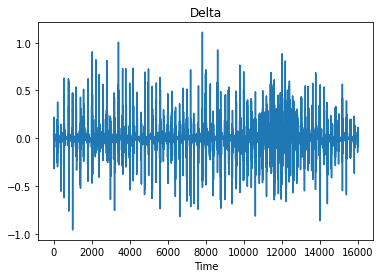

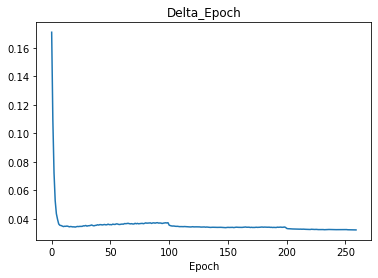

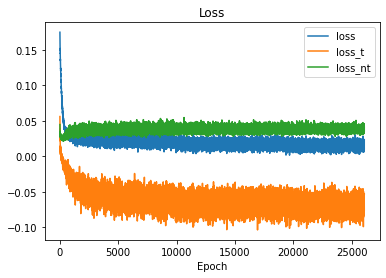

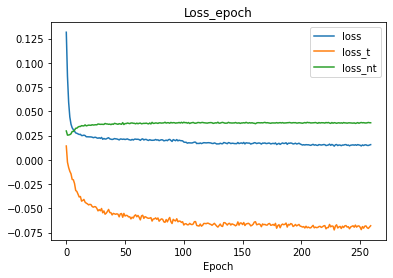

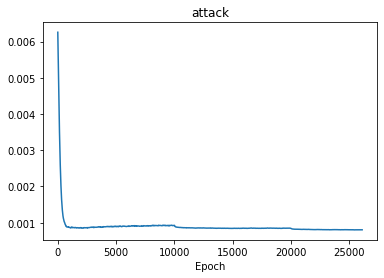

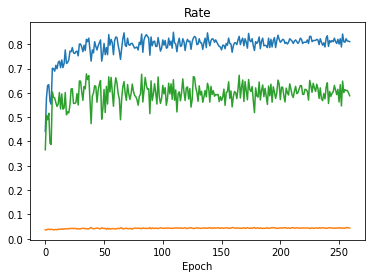

tensor([[0.0001, 0.0012, 0.0002,  ..., 0.0034, 0.0022, 0.0005]],
       grad_fn=<SqueezeBackward1>)


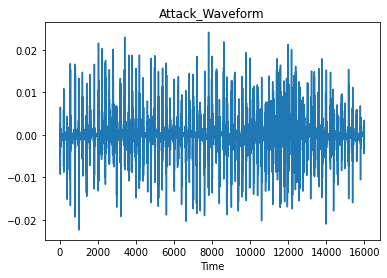

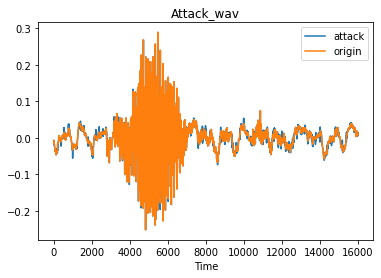


Test Epoch: 0	Attack_Accuracy: 338/412 (82%)


Test Epoch: 0	maintain_Accuracy: 480/10593 (5%)



In [23]:

time_ = time.strftime('%d_%H_%M_%S',time.localtime(time.time()))
dir_path = os.path.join('output',time_)
os.mkdir(os.path.join('output',time_)) 

print(delta)
plt.plot(delta.squeeze().detach().to('cpu').numpy())
plt.xlabel("Time")
plt.title("Delta")
plt.savefig(os.path.join(dir_path,"Delta.png"), facecolor ="w" , edgecolor = "w") 
plt.show()
plt.close()
plt.plot(delta_sum)
plt.xlabel("Epoch")
plt.title("Delta_Epoch")
plt.savefig(os.path.join(dir_path,"Delta_Epoch.png"), facecolor ="w" , edgecolor = "w")
plt.show()
plt.close()
plt.plot(losses, label='loss')
plt.plot(losses_t, label='loss_t')
plt.plot(losses_nt, label='loss_nt')
plt.legend()
plt.xlabel("Epoch")
plt.title("Loss")
plt.savefig(os.path.join(dir_path,"Loss.png"), facecolor ="w" , edgecolor = "w" )
plt.show()
plt.close()

plt.plot(losses_epoch, label='loss')
plt.plot(losses_t_epoch, label='loss_t')
plt.plot(losses_nt_epoch, label='loss_nt')
plt.legend()
plt.xlabel("Epoch")
plt.title("Loss_epoch")
plt.savefig(os.path.join(dir_path,"Loss_epoch.png"), facecolor ="w" , edgecolor = "w" )
plt.show()
plt.close()

plt.plot(delta_wav)
plt.xlabel("Epoch")
plt.title("attack")
plt.savefig(os.path.join(dir_path,"Attack.png"), facecolor ="w" , edgecolor = "w" )
plt.show()
plt.close()
plt.plot(attack_,label='attack')
plt.plot(maintain_,label='maintain')
plt.plot(error_,label='error')
plt.xlabel("Epoch")
plt.title("Rate")
plt.savefig(os.path.join(dir_path,"Rate.png"), facecolor ="w" , edgecolor = "w" )
plt.show()
plt.close()
threshold = 0.1 + (n_epoch // threshold_epoch  -1 ) * 0.07

delta_ = threshold*torch.tanh(delta)
delta_ = delta_.to('cpu')
delta_ = torch.squeeze(delta_,0)

print(delta_)
plt.plot(torch.squeeze(delta_,0).detach().numpy())
plt.xlabel("Time")
plt.title("Attack_Waveform")
plt.savefig(os.path.join(dir_path,"Attack_Waveform.png"), facecolor ="w" , edgecolor = "w")
plt.show()
plt.close()
torchaudio.save(os.path.join(dir_path,"Attack.wav"), delta_ , sample_rate=16000, channels_first=True)


test_attack(model,0,threshold_epoch, delta=delta,wav_save = True)

f = open(os.path.join(dir_path,"Parameter_2.txt"), "w")  # 打开文件
print("n_epoch=",n_epoch,file=f)
print("threshold_epoch=",threshold_epoch,file=f)
print("target:origin=1:0.5",file=f)

f.close()


In [ ]:
test_attack(model,0,threshold_epoch, delta=delta,wav_save = True)
test_attack(model,0,threshold_epoch)

In [ ]:
print(len(attack_train_loader))

Feel free to try with one of your own recordings of one of the labels!
For example, using Colab, say “Go” while executing the cell below. This
will record one second of audio and try to classify it.




Conclusion
----------

In this tutorial, we used torchaudio to load a dataset and resample the
signal. We have then defined a neural network that we trained to
recognize a given command. There are also other data preprocessing
methods, such as finding the mel frequency cepstral coefficients (MFCC),
that can reduce the size of the dataset. This transform is also
available in torchaudio as ``torchaudio.transforms.MFCC``.


